Table of contents

<h1>Import and preprocessing</h1>

In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score


df = pd.read_csv('filtered_property_location_clean.csv', delimiter=';')

#Eine Liste von Spalten zum dropen.
columns_to_drop = ['Canton','longitude','latitude','ListingId','LocationId','YearBuilt','Timestamp', 'Availability','AdditionalCost','NetPrice', 'PropertyAdditionalFeaturesId','Vendor', 'street', 'zip','PropertyDescription','bfs_number','municipality',]

#Spalten jetzt dropen.
df= df.drop(columns=columns_to_drop)

<H1>Codierung und Standardisierung der Daten</h1>

In [98]:
# Create a new DataFrame with reset index
df_reset = df.reset_index(drop=True)

# Create a new DataFrame with reset index
df_reset = df.reset_index(drop=True)

# Apply One-Hot-Encoding to the canton column

df_objectType_encoded = pd.get_dummies(df['ObjectType'])

# Explicitly convert the One-Hot-Encoding columns to int
df_objectType_encoded = df_objectType_encoded.astype(int)

# Concatenate the original DataFrame without the canton column and the result of the One-Hot-Encoding
df = pd.concat([df.drop('ObjectType', axis=1), df_objectType_encoded], axis=1)

if 'Floor' in df.columns:
    df['Floor'] = df['Floor'].replace('EG', 0)
    df['Floor'] = pd.to_numeric(df['Floor'], errors='coerce')
    # Entfernen der Zeilen, in denen 'Floor' NaN ist
    data = df.dropna(subset=['Floor'])
    # Filtere die Zeilen, bei denen 'Floor' kleiner oder gleich 10 ist
    rows_to_keep = data[data['Floor'] < 20]


df = rows_to_keep
    
# Lösche die Daten mit NaN-Werten in der Spalte 'population_density'
df = df.dropna(subset=['population_density'])

df


,Rooms,SquareMeter,Floor,Price,incometax_canton,incometax_municipality,wealthtax_canton,wealthtax_municipality,population_density,public_transport_count,...,Loft,Maisonette / Duplex,Mansarde,Mehrfamilienhaus,Reihenfamilienhaus,Studio,Terrassenhaus,Terrassenwohnung,Villa,Wohnung
0,2.5,93.0,1.0,1920.0,97.0,77.00,97.0,77.00,468.0,1,...,0,0,0,0,0,0,0,0,0,1
1,2.5,62.0,2.0,1730.0,97.0,80.00,97.0,80.00,437.0,5,...,0,0,0,0,0,0,0,0,0,1
2,2.0,58.0,3.0,910.0,97.0,84.00,97.0,84.00,1999.0,6,...,0,0,0,0,0,0,0,0,0,1
5,3.5,80.0,2.0,2000.0,97.0,77.00,97.0,77.00,468.0,3,...,0,0,0,0,0,1,0,0,0,0
6,3.5,70.0,3.0,1290.0,97.0,78.00,97.0,78.00,826.0,3,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824,9.5,220.0,5.0,10500.0,147.5,45.49,147.5,45.49,12811.0,19,...,0,0,0,0,0,0,0,0,0,1
8825,2.5,52.0,3.0,1770.0,147.5,45.49,147.5,45.49,12811.0,8,...,0,0,0,0,0,0,0,0,0,1
8826,2.5,52.0,3.0,1770.0,147.5,45.49,147.5,45.49,12811.0,8,...,0,0,0,0,0,0,0,0,0,1
8828,1.5,40.0,5.0,1540.0,147.5,45.49,147.5,45.49,12811.0,9,...,0,0,0,0,0,0,0,0,0,1


In [99]:
df.columns

Index(['Rooms', 'SquareMeter', 'Floor', 'Price', 'incometax_canton',
       'incometax_municipality', 'wealthtax_canton', 'wealthtax_municipality',
       'population_density', 'public_transport_count', 'supermarket_count',
       'foodandbeverage_count', 'Price_per_m2', 'Attikawohnung', 'Bauernhaus',
       'Chalet', 'Dachwohnung', 'Doppeleinfamilienhaus', 'Einfamilienhaus',
       'Einliegerwohnung', 'Loft', 'Maisonette / Duplex', 'Mansarde',
       'Mehrfamilienhaus', 'Reihenfamilienhaus', 'Studio', 'Terrassenhaus',
       'Terrassenwohnung', 'Villa', 'Wohnung'],
      dtype='object')

# Eingrenzung des Datasets basierend auf Höhe der Preise

### Preisdistribution anzeigen

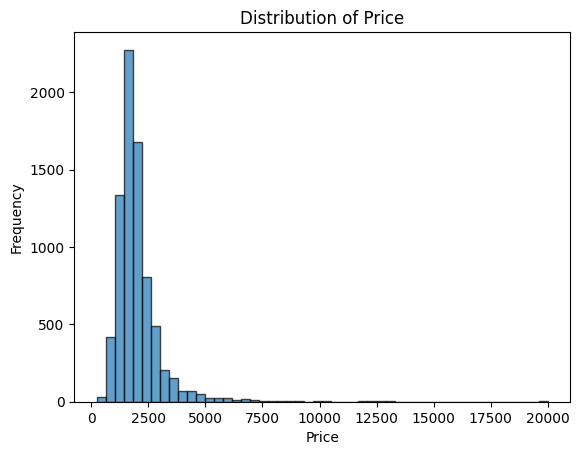

count     7729.000000
mean      2014.865183
std       1096.413875
min        250.000000
25%       1460.000000
50%       1790.000000
75%       2250.000000
max      20000.000000
Name: Price, dtype: float64


In [100]:

import matplotlib.pyplot as plt

# Plot der Verteilung der Zielvariable 'Price'
plt.hist(df['Price'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

# Überblick über die statistischen Kennzahlen der Zielvariable
price_stats = df['Price'].describe()
print(price_stats)

### Extremwerte ausgrenzen

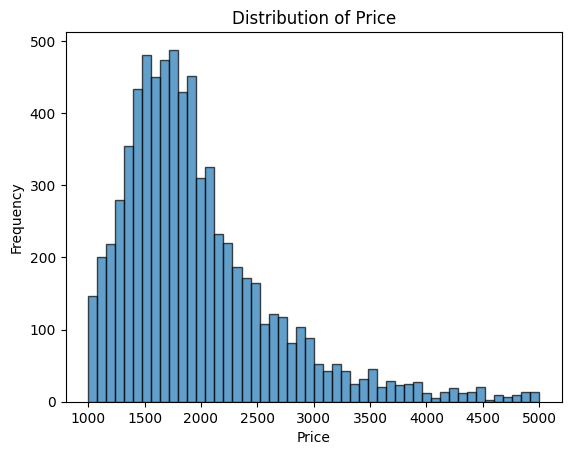

count    7199.000000
mean     1967.649535
std       683.418024
min      1000.000000
25%      1500.000000
50%      1810.000000
75%      2240.000000
max      5000.000000
Name: Price, dtype: float64


In [101]:

df = df.loc[(df['Price'] >= 1000) & 
            (df['Price'] <= 5000)]



# Plot der Verteilung der Zielvariable 'Price'
plt.hist(df['Price'], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

# Überblick über die statistischen Kennzahlen der Zielvariable
price_stats = df['Price'].describe()
print(price_stats)

<h1>Split data and train </h1>

In [102]:
# X(Unabhängige Variablen) and y(Ziel variables)
X = df.drop(columns=['Price', 'Price_per_m2'])
y = df['Price'].values

# Das Splitten der Daten zwischen Training-und Testdaten
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

# Speichere die Spaltennamen
feature_names = X.columns

<h1>Multiple Linear Regression</h1>

In [103]:

# Multiple Linear Regression
mlr = LinearRegression()
mlr.fit(X_train, y_train)
mlr_score = mlr.score(X_test, y_test)
pred_mlr = mlr.predict(X_test)
expl_mlr = explained_variance_score(y_test, pred_mlr)


# Extrahiere die Koeffizienten des Modells
coefficients = mlr.coef_

# Erstelle einen DataFrame für die Feature-Koeffizienten
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sortiere die Features nach dem absoluten Wert der Koeffizienten und wähle die Top 10 aus
top_features = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index).head(10)

mlr_score



0.4855446296020154

<h1>Decision Tree Regressor</h1>

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10; total time=   0.0s
Beste Parameter für DecisionTree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Erklärte Varianz des besten DecisionTree-Modells: 0.5815310314858744


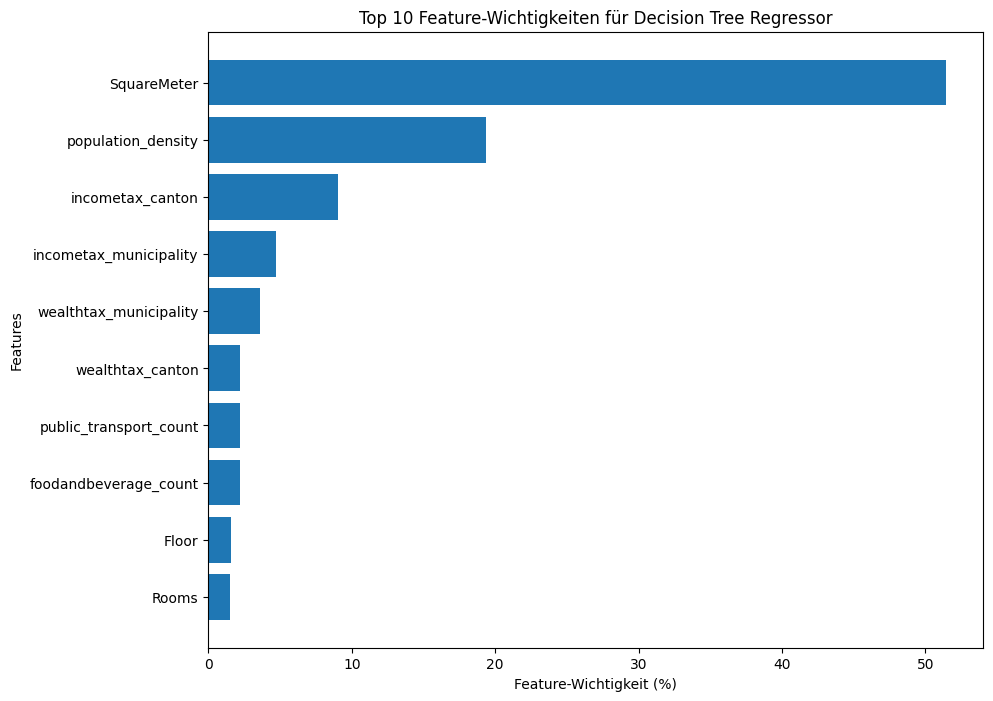

In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Definiere die zu optimierenden Hyperparameter
dt_param_grid = {
    'max_depth': [10],
    'min_samples_split': [10],
    'min_samples_leaf': [4]
}

# Erstelle das Decision Tree Regressor-Objekt
dt_regressor = DecisionTreeRegressor(random_state=0)

# Setze GridSearchCV auf
dt_grid_search = GridSearchCV(estimator=dt_regressor, param_grid=dt_param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring=make_scorer(explained_variance_score))

# Trainiere das Modell
dt_grid_search.fit(X_train, y_train)
dt_best_model = dt_grid_search.best_estimator_
print(f"Beste Parameter für DecisionTree: {dt_grid_search.best_params_}")

# Evaluierung des besten Modells
dt_best_pred = dt_best_model.predict(X_test)
dt_best_score = explained_variance_score(y_test, dt_best_pred)
print(f"Erklärte Varianz des besten DecisionTree-Modells: {dt_best_score}")

# Feature-Wichtigkeiten für DecisionTreeRegressor
dt_importances = dt_best_model.feature_importances_

# Erstelle ein DataFrame für die Feature-Wichtigkeiten
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_importances
})



# Sortiere die Features nach Wichtigkeit und wähle die Top 10 aus
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Konvertiere Wichtigkeiten in Prozentsätze
top_features['Importance'] = top_features['Importance'] * 100

# Plot der Feature-Wichtigkeiten
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel("Feature-Wichtigkeit (%)")
plt.ylabel("Features")
plt.title("Top 10 Feature-Wichtigkeiten für Decision Tree Regressor")
plt.gca().invert_yaxis()  # Zeige das wichtigste Feature oben an
plt.show()

# Berechne und drucke MSE, RMSE, MAE und R² für das Decision Tree-Modell
mse_best_dt = mean_squared_error(y_test, dt_best_pred)
rmse_best_dt = np.sqrt(mse_best_dt)
mae_best_dt = mean_absolute_error(y_test, dt_best_pred)
r2_best_dt = r2_score(y_test, dt_best_pred)
expl_dt = explained_variance_score(y_test, dt_best_pred)
dtr_score = round(dt_best_model.score(X_test, y_test) * 100)


<h1>Random Forest Regressor</h1>

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.2s
Beste Parameter für RandomForest: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Erklärte Varianz des besten RandomForest-Modells: 0.6990876692622273


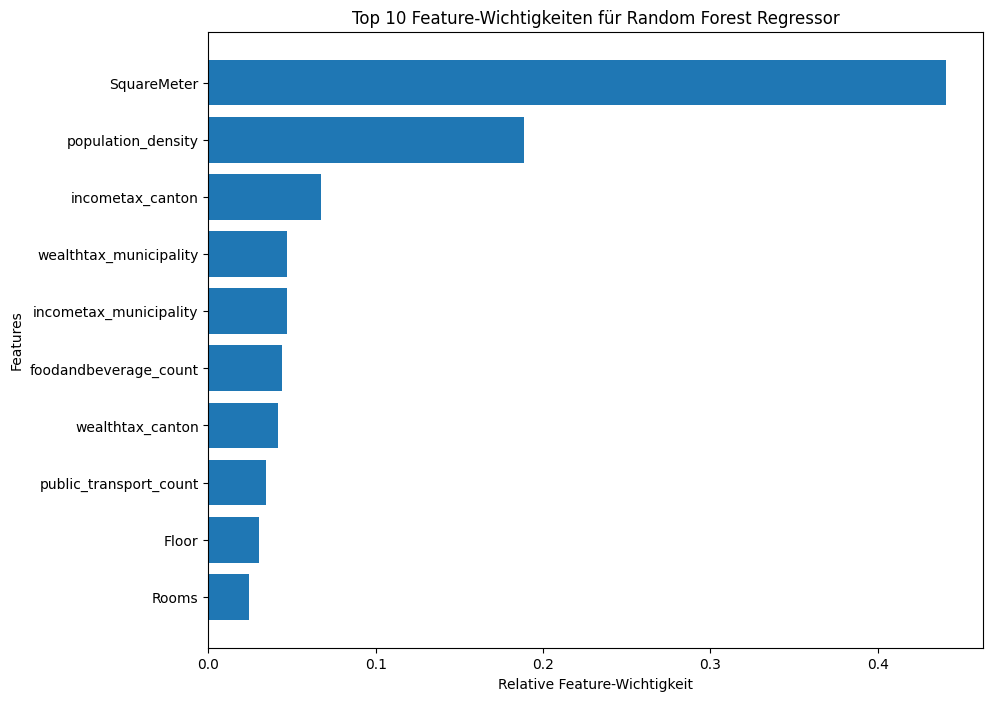

In [105]:
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Definiere die zu optimierenden Hyperparameter
rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [30],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'bootstrap': [True]
}

# Erstelle das Random Forest Regressor-Objekt
rf_regressor = RandomForestRegressor(random_state=0)

# Setze GridSearchCV auf
rf_grid_search = GridSearchCV(estimator=rf_regressor, param_grid=rf_param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring=make_scorer(explained_variance_score))

# Trainiere das Modell
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_
print(f"Beste Parameter für RandomForest: {rf_grid_search.best_params_}")

# Evaluierung des besten Modells
rf_best_pred = rf_best_model.predict(X_test)
rf_best_score = explained_variance_score(y_test, rf_best_pred)
print(f"Erklärte Varianz des besten RandomForest-Modells: {rf_best_score}")

forest_importances = rf_best_model.feature_importances_

# Erstelle ein DataFrame für die Feature-Wichtigkeiten
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': forest_importances
})

# Sortiere die Features nach Wichtigkeit und wähle die Top 10 aus
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Konvertiere Wichtigkeiten in Prozentsätze
#top_features['Importance'] = top_features['Importance'] * 100

# Plot der Feature-Wichtigkeiten
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel("Relative Feature-Wichtigkeit")
plt.ylabel("Features")
plt.title("Top 10 Feature-Wichtigkeiten für Random Forest Regressor")
plt.gca().invert_yaxis()  # Zeige das wichtigste Feature oben an
plt.show()

# Berechne und drucke MSE, RMSE, MAE und R²
mse_best_rf = mean_squared_error(y_test, rf_best_pred)
rmse_best_rf = np.sqrt(mse_best_rf)
mae_best_rf = mean_absolute_error(y_test, rf_best_pred)
r2_best_rf = r2_score(y_test, rf_best_pred)


<h1>XGBOOST</h1>

### Training on all features

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.1s


[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.7; total time=   0.2s
[CV] END 

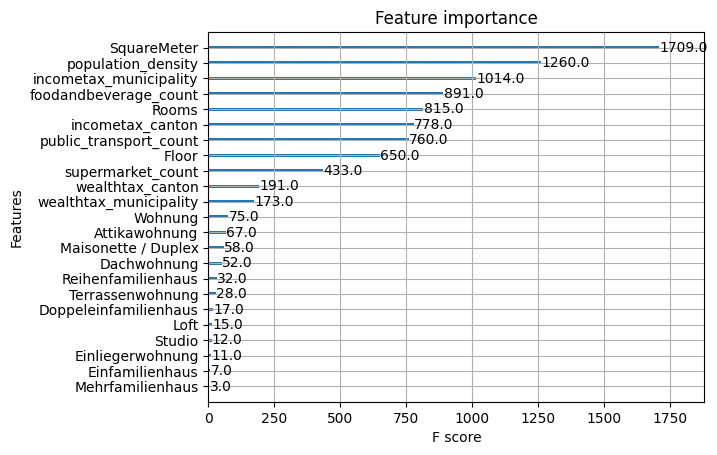

In [106]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Definiere die zu optimierenden Hyperparameter
xgb_param_grid = {
    'n_estimators': list(range(50, 500, 50)),
    'max_depth': list(range(5, 30, 5)),
    'learning_rate': [0.1],
    'subsample': [0.7],
    'colsample_bytree': [0.9],
    'gamma': [0]
}

# Erstelle das XGBRegressor-Objekt
xgb_regressor = XGBRegressor(random_state=0)

# Setze GridSearchCV auf
xgb_grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=xgb_param_grid, 
                               cv=5, n_jobs=-1, verbose=2, scoring=make_scorer(r2_score))

# Trainiere das Modell
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_
print(f"Beste Parameter für XGBRegressor: {xgb_grid_search.best_params_}")

# Evaluierung des besten Modells
xgb_best_pred = xgb_best_model.predict(X_test)
xgb_best_score = explained_variance_score(y_test, xgb_best_pred)
print(f"Erklärte Varianz des besten XGBRegressor-Modells: {xgb_best_score}")

# Feature-Wichtigkeiten für XGBRegressor
xgb_importances = xgb_best_model.feature_importances_

# Erstelle ein DataFrame für die Feature-Wichtigkeiten
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
})


# Sortiere die Features nach Wichtigkeit und wähle die Top 10 aus
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Konvertiere Wichtigkeiten in Prozentsätze
#top_features['Importance'] = top_features['Importance'] * 100

#Plot der Feature-Wichtigkeiten ohne kantonbezogene Features
# plt.figure(figsize=(10, 8))
# plt.barh(top_features['Feature'], top_features['Importance'])
# plt.xlabel("Relative Feature-Wichtigkeit")
# plt.ylabel("Features")
# plt.title("Top 10 Feature-Wichtigkeiten für XGBoost Regressor")
# plt.gca().invert_yaxis()  # Zeige das wichtigste Feature oben an
# plt.show()

plot_importance(xgb_best_model)
plt.show()

# Berechne und drucke MSE, RMSE, MAE und R² für das XGBoost-Modell
mse_best_xgb = mean_squared_error(y_test, xgb_best_pred)
rmse_best_xgb = np.sqrt(mse_best_xgb)
mae_best_xgb = mean_absolute_error(y_test, xgb_best_pred)
r2_best_xgb = r2_score(y_test, xgb_best_pred)


## Removing weak features and retraining XBoost

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=5, n_e

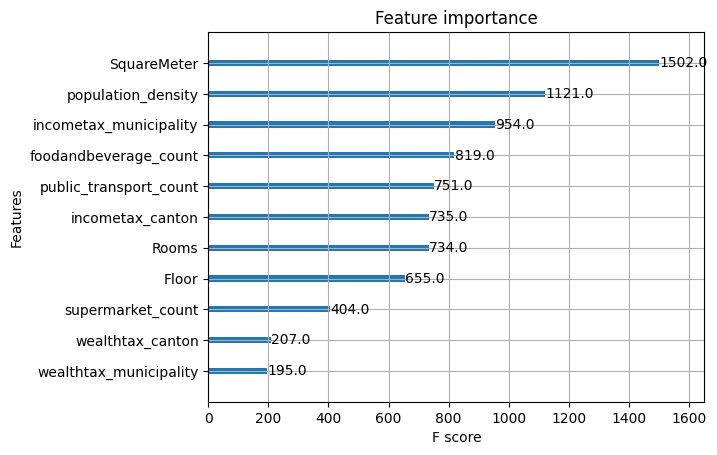

In [107]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Remove 'ObjectType' variable and redefine X
X = df.drop(columns=['Price', 'Price_per_m2', 'Attikawohnung', 'Bauernhaus',
       'Chalet', 'Dachwohnung', 'Doppeleinfamilienhaus', 'Einfamilienhaus',
       'Einliegerwohnung', 'Loft', 'Maisonette / Duplex', 'Mansarde',
       'Mehrfamilienhaus', 'Reihenfamilienhaus', 'Studio', 'Terrassenhaus',
       'Terrassenwohnung', 'Villa', 'Wohnung'])
y = df['Price'].values

# Das Splitten der Daten zwischen Training-und Testdaten
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

# Speichere die Spaltennamen
feature_names = X.columns



# Definiere die zu optimierenden Hyperparameter
xgb_param_grid = {
    'n_estimators': list(range(50, 500, 50)),
    'max_depth': list(range(5, 30, 5)),
    'learning_rate': [0.1],
    'subsample': [0.7],
    'colsample_bytree': [0.9],
    'gamma': [0]
}

# Erstelle das XGBRegressor-Objekt
xgb_regressor = XGBRegressor(random_state=0)

# Setze GridSearchCV auf
xgb_grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=xgb_param_grid, 
                               cv=5, n_jobs=-1, verbose=2, scoring=make_scorer(r2_score))

# Trainiere das Modell
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_
print(f"Beste Parameter für XGBRegressor: {xgb_grid_search.best_params_}")

# Evaluierung des besten Modells
xgb_best_pred = xgb_best_model.predict(X_test)
xgb_best_score = explained_variance_score(y_test, xgb_best_pred)
print(f"Erklärte Varianz des besten XGBRegressor-Modells: {xgb_best_score}")

# Feature-Wichtigkeiten für XGBRegressor
xgb_importances = xgb_best_model.feature_importances_

# Erstelle ein DataFrame für die Feature-Wichtigkeiten
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
})


# Sortiere die Features nach Wichtigkeit und wähle die Top 10 aus
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Konvertiere Wichtigkeiten in Prozentsätze
#top_features['Importance'] = top_features['Importance'] * 100

#Plot der Feature-Wichtigkeiten ohne kantonbezogene Features
# plt.figure(figsize=(10, 8))
# plt.barh(top_features['Feature'], top_features['Importance'])
# plt.xlabel("Relative Feature-Wichtigkeit")
# plt.ylabel("Features")
# plt.title("Top 10 Feature-Wichtigkeiten für XGBoost Regressor")
# plt.gca().invert_yaxis()  # Zeige das wichtigste Feature oben an
# plt.show()

plot_importance(xgb_best_model)
plt.show()

# Berechne und drucke MSE, RMSE, MAE und R² für das XGBoost-Modell
mse_best_xgb = mean_squared_error(y_test, xgb_best_pred)
rmse_best_xgb = np.sqrt(mse_best_xgb)
mae_best_xgb = mean_absolute_error(y_test, xgb_best_pred)
r2_best_xgb = r2_score(y_test, xgb_best_pred)


Modell bewerten

Schritt 7: Modell verwenden für Vorhersagen

In [108]:
# MeanSquaredError und RootMeanSquaredError und MeanAbsolutError,

expl_rf = explained_variance_score(y_test, rf_best_pred)
expl_dt = explained_variance_score(y_test, dt_best_pred)
mae_best_xgb = mean_absolute_error(y_test, xgb_best_pred)
r2_best_rf = r2_score(y_test, rf_best_pred)


# Erstelle ein Ranking der Modelle in einer Tabelle
models_score = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Mean Squared Error (MSE):': [np.round(mse_best_dt,decimals=2), np.round(mse_best_rf,decimals=2), np.round(mse_best_xgb,decimals=2)],
    'Root Mean Squared Error (RMSE)': [np.round(rmse_best_dt,decimals=2), np.round(rmse_best_rf,decimals=2), np.round(rmse_best_xgb,decimals=2)],
    'Mean Absolute Error (MAE)': [np.round(mae_best_dt,decimals=2), np.round(mae_best_rf,decimals=2), np.round(mae_best_xgb,decimals=2)],
    'R Squared (R2)': [np.round(r2_best_dt,decimals=4), np.round(r2_best_rf,decimals=4), np.round(r2_best_xgb, decimals=4)]
})


# Sortiere die Tabelle nach den Fehlerkennzahlen
models_score = models_score.sort_values(by=['Mean Squared Error (MSE):', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)', 'R Squared (R2)'], ascending=True)
models_score

,Model,Mean Squared Error (MSE):,Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R Squared (R2)
2,XGBoost,122921.51,350.60,245.15,0.7418
1,Random Forest,143416.59,378.70,259.39,0.6988
0,Decision Tree,199240.95,446.36,309.83,0.5815


## Modell speichern

In [110]:
# import joblib

# model = xgb_best_model
# ref_cols=list(X.columns)
# target = 'Price'

# joblib.dump(value=[model, ref_cols, target], filename='XGBoost_model.pkl')

['XGBoost_model.pkl']